<a href="https://colab.research.google.com/github/nteuthorn/Thinkful-Capstone-2/blob/master/Capstone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import scipy.stats as stats
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [2]:
#Import 2015 and 2017 census data, change column names to be consistent across datasets

df2015 = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Thinkful/Completed/Capstone 2/acs2015_census_tract_data.csv')

df2017 = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Thinkful/Completed/Capstone 2/acs2017_census_tract_data.csv')
df2017.rename({'TractId': 'CensusTract', 'VotingAgeCitizen': 'Citizen'}, axis=1, inplace=True)

In [3]:
# #Change count statistics to percentages based on total population; remove %women because of perfect multicollinearity with %men

# df2015['Men'] = df2015['Men']/df2015['TotalPop']
# df2015['Citizen'] = df2015['Citizen']/df2015['TotalPop']
# df2015['Employed'] = df2015['Employed']/df2015['TotalPop']
# df2015.drop(['CensusTract', 'Women'], axis=1, inplace=True)

# df2017['Men'] = df2017['Men']/df2017['TotalPop']
# df2017['Citizen'] = df2017['Citizen']/df2017['TotalPop']
# df2017['Employed'] = df2017['Employed']/df2017['TotalPop']
# df2017.drop(['CensusTract', 'Women'], axis=1, inplace=True)

In [4]:
df2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      74001 non-null  int64  
 1   State            74001 non-null  object 
 2   County           74001 non-null  object 
 3   TotalPop         74001 non-null  int64  
 4   Men              74001 non-null  int64  
 5   Women            74001 non-null  int64  
 6   Hispanic         73311 non-null  float64
 7   White            73311 non-null  float64
 8   Black            73311 non-null  float64
 9   Native           73311 non-null  float64
 10  Asian            73311 non-null  float64
 11  Pacific          73311 non-null  float64
 12  Citizen          74001 non-null  int64  
 13  Income           72901 non-null  float64
 14  IncomeErr        72901 non-null  float64
 15  IncomePerCap     73261 non-null  float64
 16  IncomePerCapErr  73261 non-null  float64
 17  Poverty     

In [5]:
#Create df_diff as change from 2015 to 2017
#Add Poverty_Change variable as categorical, -1=significant decrease in poverty, 0=no significant change, +1=significant increase in poverty

df_diff = df2017[['Poverty']].copy()
df_diff['Poverty'] = df2017['Poverty'] - df2015['Poverty']
df_diff['Poverty_Change'] = 1
df_diff.loc[(df_diff['Poverty'] >= 1.5), 'Poverty_Change'] = 2
df_diff.loc[(df_diff['Poverty'] <= -1.5), 'Poverty_Change'] = 0

#Add poverty change to 2015 dataset
df2015['Poverty_Change'] = df_diff['Poverty_Change']
df2015['Poverty_Change_val'] = df_diff['Poverty']

df2015['Poverty_Change_2c'] = 0
df2015.loc[(df2015['Poverty_Change_val'] > 0), 'Poverty_Change_2c'] = 1

df2015['Poverty_Change_2c_2'] = 0
df2015.loc[(df2015['Poverty_Change_val'] > 1.5), 'Poverty_Change_2c_2'] = 1

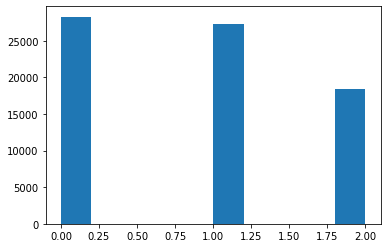

In [6]:
plt.hist(df2015['Poverty_Change'])
plt.show()

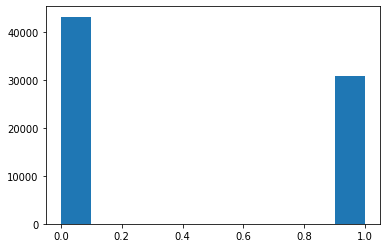

In [7]:
plt.hist(df2015['Poverty_Change_2c'])
plt.show()

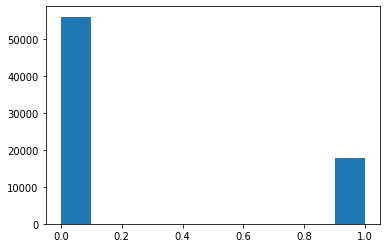

In [8]:
plt.hist(df2015['Poverty_Change_2c_2'])
plt.show()

In [9]:
# #Create PCA components for a combination of 'State' and 'County' variables

# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(pd.concat([pd.get_dummies(df2015['State']), pd.get_dummies(df2015['County'])], axis=1))

# principalDf = pd.DataFrame(data = principal_components)
# df2015 = pd.concat([df2015, principalDf], axis=1)

In [10]:
#Drop null values

df2015.dropna(inplace=True)
df_diff.dropna(inplace=True)

In [11]:
# #Winsorize outliers

# for col in df2015.columns[2:]:
#     threshold = 5
#     q75, q25 = np.percentile(df2015[col], [75,25])
#     iqr = q75-q25
#     min_val = q25 - (iqr*threshold)
#     max_val = q75 + (iqr*threshold)

#     outliers = df2015[(df2015[col] > max_val) | (df2015[col] < min_val)]
#     print(col)
#     print('There are {} tracts identified as outliers.'.format(outliers.shape[0]))

#     df2015[col] = pd.Series(winsorize(df2015[col], limits = (outliers.shape[0]/df2015[col].shape[0])))

# for col in df_diff.columns:
#     threshold = 3
#     q75, q25 = np.percentile(df_diff[col], [75,25])
#     iqr = q75-q25
#     min_val = q25 - (iqr*threshold)
#     max_val = q75 + (iqr*threshold)

#     outliers = df_diff[(df_diff[col] > max_val) | (df_diff[col] < min_val)]
#     print(col)
#     print('There are {} tracts identified as outliers.'.format(outliers.shape[0]))

#     df_diff[col] = pd.Series(winsorize(df_diff[col], limits = (outliers.shape[0]/df_diff[col].shape[0])))

In [12]:
# #Drop null values

# df2015.dropna(inplace=True)
# df_diff.dropna(inplace=True)

In [13]:
#Create y-variable as categorical poverty change, X variable as all 2015 statistics
#Perform train test split; also create "small" dataset for faster computation during testing
#Create scaled dataset for use when necessary

y = df2015['Poverty_Change']
y_2c = df2015['Poverty_Change_2c']
y_2c_2 = df2015['Poverty_Change_2c_2']

#Remove ChildPoverty and PrivateWork for too much correlation with Poverty and PublicWork respectively

X = df2015.drop(['State', 'County', 'Poverty_Change', 'Poverty_Change_val', 'Poverty_Change_2c', 'Poverty_Change_2c_2'], axis=1)

# df_small = df2015.sample(frac=0.1)
# y_small = df_small['Poverty_Change_2c']
# X_small = df_small.drop(['State', 'County', 'Poverty_Change', 'Poverty_Change_val', 'Poverty_Change_2c'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train_2c, X_test_2c, y_train_2c, y_test_2c = train_test_split(X,y_2c,test_size=0.2)
X_train_2c_2, X_test_2c_2, y_train_2c_2, y_test_2c_2 = train_test_split(X,y_2c_2,test_size=0.2)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_small,y_small,test_size=0.2)

scaler = StandardScaler()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_train_scale_2c = pd.DataFrame(scaler.fit_transform(X_train_2c), columns = X_train_2c.columns)
X_test_scale_2c = pd.DataFrame(scaler.transform(X_test_2c), columns = X_test_2c.columns)
X_train_scale_2c_2 = pd.DataFrame(scaler.fit_transform(X_train_2c_2), columns = X_train_2c_2.columns)
X_test_scale_2c_2 = pd.DataFrame(scaler.transform(X_test_2c_2), columns = X_test_2c_2.columns)
# X_train_s_scale = pd.DataFrame(scaler.fit_transform(X_train_s), columns = X_train_s.columns)
# X_test_s_scale = pd.DataFrame(scaler.fit_transform(X_test_s), columns = X_test_s.columns)

In [14]:
#Oversample training data to equalize class sizes

sm = SMOTE()

X_train_res, y_train_res = sm.fit_resample(X_train_scale, y_train)
X_train_res_2c, y_train_res_2c = sm.fit_resample(X_train_scale_2c, y_train_2c)
X_train_res_2c_2, y_train_res_2c_2 = sm.fit_resample(X_train_scale_2c_2, y_train_2c_2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

0.3873496046751461
0.3891791557816582


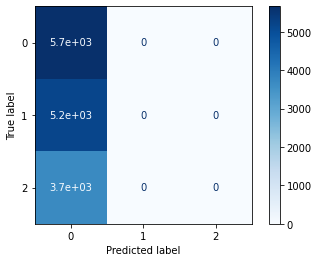

In [16]:
#Perform dummy classification for baseline

dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)

print(dummy.score(X_train, y_train))
print(dummy.score(X_test, y_test))

plot_confusion_matrix(dummy, X_test, y_test, cmap='Blues')

0.5805431419731867
0.5735597415096934


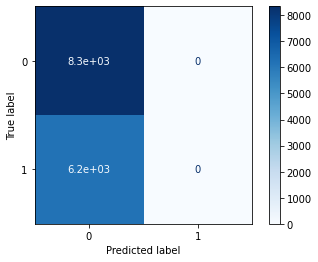

In [ ]:
#Perform dummy classification for baseline

dummy_2c = DummyClassifier(strategy = 'most_frequent')
dummy_2c.fit(X_train_2c, y_train_2c)

print(dummy_2c.score(X_train_2c, y_train_2c))
print(dummy_2c.score(X_test_2c, y_test_2c))

plot_confusion_matrix(dummy_2c, X_test_2c, y_test_2c, cmap='Blues')

# Multiple models were analyzed, including logistic regression, support vector machines, random forest, and gradient boosting models. Models were tested on unmodified training data (scaled where appropriate) and oversampled data. Logistic regression trained on oversampled data was determined to be the best model due to highest recall for the +1 class while maintaining a similar overall accuracy score to the other models.

Perform analysis on a series of logistic regression models to identify best parameters

--- 6.911752462387085 seconds ---
The train accuracy score is 51.79%.
The test accuracy score is 52.03%.
The 2 class F1 score is 21.54%.


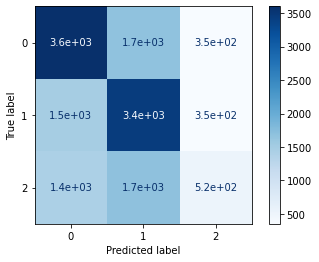

In [26]:
#Logistic regression model: poor predictor of +1 class

start_time = time.time()

logit = LogisticRegression(max_iter=10000)

logit.fit(X_train_scale, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(logit.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(logit.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, logit.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 6.030704736709595 seconds ---
The train accuracy score is 49.32%.
The test accuracy score is 49.77%.
The 2 class F1 score is 37.91%.


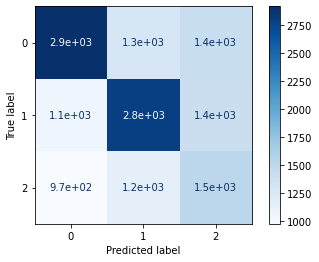

In [27]:
#Logistic regression model with oversampled data: overfits to +1 class

start_time = time.time()

logit_res = LogisticRegression(max_iter=10000)

logit_res.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_res, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(logit_res.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(logit_res.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 2.113581418991089 seconds ---
The train accuracy score is 45.52%.
The test accuracy score is 45.52%.
The 2 class F1 score is 37.49%.


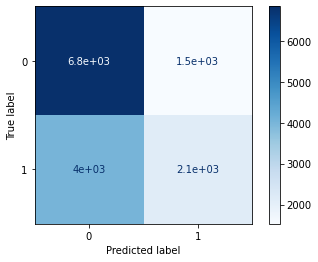

In [38]:
#2 category: cannot predict +1 class

start_time = time.time()

logit_2c = LogisticRegression(max_iter=10000)

logit_2c.fit(X_train_scale_2c, y_train_2c)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_2c, X_test_scale_2c, y_test_2c, cmap='Blues')
print(f'The train accuracy score is {round(logit_2c.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(logit_2c.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, logit_2c.predict(X_test_scale), average=None)[1]*100,2)}%.')

--- 0.9690191745758057 seconds ---
The train accuracy score is 49.16%.
The test accuracy score is 49.18%.
The 2 class F1 score is 53.81%.


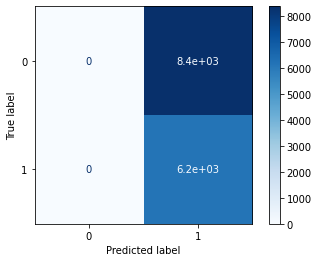

In [39]:
#2 category with resample: worse

start_time = time.time()

logit_res_2c = LogisticRegression(max_iter=10000)

logit_res_2c.fit(X_train_res_2c, y_train_res_2c)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_res_2c, X_test_2c, y_test_2c, cmap='Blues')
print(f'The train accuracy score is {round(logit_res_2c.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(logit_res_2c.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_2c.predict(X_test_scale), average=None)[1]*100,2)}%.')

In [30]:
# #2 category 2: 

# start_time = time.time()

# logit_2c_2 = LogisticRegression(max_iter=10000)

# logit_2c_2.fit(X_train_scale_2c_2, y_train_2c_2)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_2c_2, X_test_scale_2c_2, y_test_2c_2, cmap='Blues')
# print(f'The train accuracy score is {round(logit_2c_2.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_2c_2.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_2c_2.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [31]:
# #2 category 2 (combine 0 class and 1 class as single category): 

# start_time = time.time()

# logit_res_2c_2 = LogisticRegression(max_iter=10000)

# logit_res_2c_2.fit(X_train_res_2c_2, y_train_res_2c_2)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_2c_2, X_test_scale_2c_2, y_test_2c_2, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_2c_2.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_2c_2.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_2c_2.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
# #Using saga solver: no improvement

# start_time = time.time()

# logit_res_saga = LogisticRegression(max_iter=10000, solver='saga')

# logit_res_saga.fit(X_train_res, y_train_res)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_saga, X_test_scale, y_test, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_saga.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_saga.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_saga.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
# #Using saga solver and l1 penalty: no improvement

# start_time = time.time()

# logit_res_saga2 = LogisticRegression(max_iter=10000, solver='saga', penalty='l1')

# logit_res_saga2.fit(X_train_res, y_train_res)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_saga2, X_test_scale, y_test, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_saga2.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_saga2.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_saga2.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
# #Using saga solver and elasticnet penalty: no improvement

# start_time = time.time()

# logit_res_saga3 = LogisticRegression(max_iter=10000, solver='saga', penalty='elasticnet', l1_ratio=0.5)

# logit_res_saga3.fit(X_train_res, y_train_res)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_saga3, X_test_scale, y_test, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_saga3.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_saga3.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_saga3.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
# #Using saga solver and ovr comparison: no improvement

# start_time = time.time()

# logit_res_saga_ovr = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr')

# logit_res_saga_ovr.fit(X_train_res, y_train_res)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_saga_ovr, X_test_scale, y_test, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_saga_ovr.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_saga_ovr.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_saga_ovr.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
# #Using saga solver, l1 penalty and ovr comparison: no improvement

# start_time = time.time()

# logit_res_saga_ovr2 = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', penalty='l1')

# logit_res_saga_ovr2.fit(X_train_res, y_train_res)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_saga_ovr2, X_test_scale, y_test, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_saga_ovr2.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_saga_ovr2.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_saga_ovr2.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
# #Using saga solver, elasticnet penalty and ovr comparison: no improvement

# start_time = time.time()

# logit_res_saga_ovr3 = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', penalty='elasticnet', l1_ratio=0.5)

# logit_res_saga_ovr3.fit(X_train_res, y_train_res)

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_res_saga_ovr3, X_test_scale, y_test, cmap='Blues')
# print(f'The train accuracy score is {round(logit_res_saga_ovr3.score(X_train_scale, y_train)*100,2)}%.')
# print(f'The test accuracy score is {round(logit_res_saga_ovr3.score(X_test_scale, y_test)*100,2)}%.')
# print(f'The 2 class F1 score is {round(f1_score(y_test, logit_res_saga_ovr3.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 7.052691221237183 seconds ---
The train accuracy score is 51.74%.
The test accuracy score is 51.79%.
The 2 class F1 score is 0.0%.


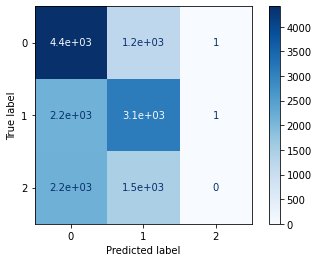

In [32]:
#Random forest model: poor predictor of +1 class

start_time = time.time()

forest = RandomForestClassifier(n_estimators=100, max_depth=4)

forest.fit(X_train_scale, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(forest, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(forest.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(forest.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, forest.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 9.839483976364136 seconds ---
The train accuracy score is 51.89%.
The test accuracy score is 52.13%.
The 2 class F1 score is 25.89%.


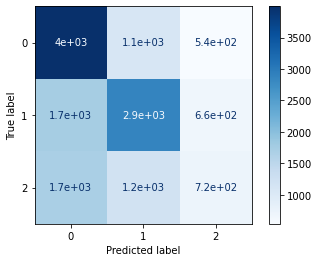

In [33]:
#Random forest model with oversampled data: not a significant improvement

start_time = time.time()

forest_res = RandomForestClassifier(n_estimators=100, max_depth=4)

forest_res.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(forest_res, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(forest_res.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(forest_res.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, forest_res.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 142.37489080429077 seconds ---
The train accuracy score is 54.59%.
The test accuracy score is 53.32%.
The 2 class F1 score is 18.22%.


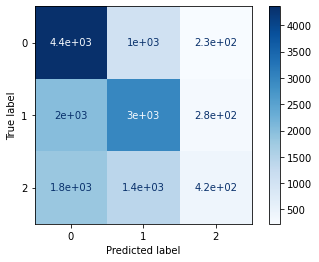

In [34]:
#Gradient boosting model: poor predictor of +1 class

start_time = time.time()

gboost = GradientBoostingClassifier(n_estimators=100, max_depth=3)

gboost.fit(X_train_scale, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(gboost, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(gboost.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(gboost.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, gboost.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 203.20423698425293 seconds ---
The train accuracy score is 53.77%.
The test accuracy score is 52.85%.
The 2 class F1 score is 32.92%.


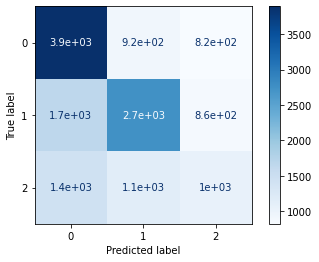

In [35]:
#Gradient boosting model with oversampled data: overfits to +1 class

start_time = time.time()

gboost_res = GradientBoostingClassifier(n_estimators=100, max_depth=3)

gboost_res.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(gboost_res, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(gboost_res.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(gboost_res.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, gboost_res.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 590.5096499919891 seconds ---
The train accuracy score is 55.97%.
The test accuracy score is 53.2%.
The 2 class F1 score is 16.94%.


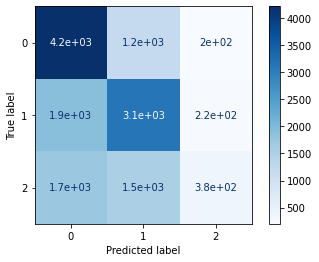

In [36]:
#Support vector machine model: poor predictor of +1 class

start_time = time.time()

svc = SVC()

svc.fit(X_train_scale, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(svc, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(svc.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(svc.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, svc.predict(X_test_scale), average=None)[2]*100,2)}%.')

--- 764.2515251636505 seconds ---
The train accuracy score is 56.38%.
The test accuracy score is 51.6%.
The 2 class F1 score is 37.14%.


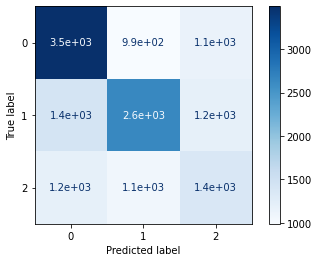

In [37]:
#Support vector machine model with oversampled data; works well, takes ~15 minutes to run

start_time = time.time()

svc_res = SVC()

svc_res.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(svc_res, X_test_scale, y_test, cmap='Blues')
print(f'The train accuracy score is {round(svc_res.score(X_train_scale, y_train)*100,2)}%.')
print(f'The test accuracy score is {round(svc_res.score(X_test_scale, y_test)*100,2)}%.')
print(f'The 2 class F1 score is {round(f1_score(y_test, svc_res.predict(X_test_scale), average=None)[2]*100,2)}%.')

In [ ]:
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns).astype(np.float32)
X_test_scale = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns).astype(np.float32)

train_dataset = data.Dataset.from_tensor_slices((X_train_scale.values, y_train.values))
test_dataset = data.Dataset.from_tensor_slices((X_test_scale.values, y_test.values))

train_dataset = train_dataset.shuffle(len(X_train_scale)).batch(10)
test_dataset = test_dataset.shuffle(len(X_test_scale)).batch(1)

In [ ]:
#Neural network

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model

In [ ]:
model = get_compiled_model()
model.fit(train_dataset, epochs=15)

score = model.evaluate(train_dataset, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('_____________________')
score = model.evaluate(test_dataset, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/15
5818/5818 [==============================] - 12s 2ms/step - loss: 1.0092 - accuracy: 0.5078
Epoch 2/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9850 - accuracy: 0.5238
Epoch 3/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9790 - accuracy: 0.5290
Epoch 4/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9744 - accuracy: 0.5300
Epoch 5/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9724 - accuracy: 0.5322
Epoch 6/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9710 - accuracy: 0.5322
Epoch 7/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9689 - accuracy: 0.5306
Epoch 8/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9672 - accuracy: 0.5343
Epoch 9/15
5818/5818 [==============================] - 12s 2ms/step - loss: 0.9662 - accuracy: 0.5342
Epoch 10/15
5818/5818 [==============================] - 12s 2ms/step - l

2 Category Neural Network

In [ ]:
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_2c), columns = X_train_2c.columns).astype(np.float32)
X_test_scale = pd.DataFrame(scaler.fit_transform(X_test_2c), columns = X_test_2c.columns).astype(np.float32)

train_dataset = data.Dataset.from_tensor_slices((X_train_scale.values, y_train_2c.values))
test_dataset = data.Dataset.from_tensor_slices((X_test_scale.values, y_test_2c.values))

train_dataset = train_dataset.shuffle(len(X_train_scale)).batch(10)
test_dataset = test_dataset.shuffle(len(X_test_scale)).batch(1)

In [ ]:
#Neural network

def get_compiled_model2():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  return model

In [ ]:
model2 = get_compiled_model2()
model2.fit(train_dataset, epochs=15)

score = model.evaluate(train_dataset, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('_____________________')
score = model.evaluate(test_dataset, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6602 - accuracy: 0.6063
Epoch 2/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6453 - accuracy: 0.6300
Epoch 3/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6412 - accuracy: 0.6347
Epoch 4/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6397 - accuracy: 0.6351
Epoch 5/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6374 - accuracy: 0.6368
Epoch 6/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6373 - accuracy: 0.6373
Epoch 7/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6360 - accuracy: 0.6398
Epoch 8/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6344 - accuracy: 0.6408
Epoch 9/15
5818/5818 [==============================] - 14s 2ms/step - loss: 0.6333 - accuracy: 0.6430
Epoch 10/15
5818/5818 [==============================] - 14s 2ms/step - l

# After analyzing multiple parameters in logistic regression, including normalization levels (C parameter), multivariate analysis method, and loss function, the best model was determined to be a multivariate analysis with L2 loss. Normalization level did not have a significant impact on any of the models, so C=1 was chosen for best run time.

In [ ]:
# c = [0.1, 0.5, 1, 10, 20, 40 ,70, 90, 100]

In [ ]:
# for i in c:
#     start_time = time.time()

#     logit_res_saga = LogisticRegression(max_iter=10000, solver='saga', C=i)

#     logit_res_saga.fit(X_train_res, y_train_res)
#     print(logit_res_saga.score(X_train_res, y_train_res))
#     print(logit_res_saga.score(X_train_scale, y_train))
#     print(logit_res_saga.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_res_saga, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [ ]:
# for i in c:
#     start_time = time.time()

#     logit_res_saga2 = LogisticRegression(max_iter=10000, solver='saga', penalty='l1', C=i)

#     logit_res_saga2.fit(X_train_res, y_train_res)
#     print(logit_res_saga2.score(X_train_res, y_train_res))
#     print(logit_res_saga2.score(X_train_scale, y_train))
#     print(logit_res_saga2.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_res_saga2, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [ ]:
# for i in c:
#     start_time = time.time()

#     logit_res_saga_ovr = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', C=i)

#     logit_res_saga_ovr.fit(X_train_res, y_train_res)
#     print(logit_res_saga_ovr.score(X_train_res, y_train_res))
#     print(logit_res_saga_ovr.score(X_train_scale, y_train))
#     print(logit_res_saga_ovr.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_res_saga_ovr, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [ ]:
# for i in c:
#     start_time = time.time()

#     logit_res_saga_ovr2 = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', penalty='l1', C=i)

#     logit_res_saga_ovr2.fit(X_train_res, y_train_res)
#     print(logit_res_saga_ovr2.score(X_train_res, y_train_res))
#     print(logit_res_saga_ovr2.score(X_train_scale, y_train))
#     print(logit_res_saga_ovr2.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_res_saga_ovr2, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [ ]:
# start_time = time.time()

# logit_final = LogisticRegression(max_iter=10000, solver='saga')

# logit_final.fit(X_train_res, y_train_res)
# print(logit_final.score(X_train_res, y_train_res))
# print(logit_final.score(X_train_scale, y_train))
# print(logit_final.score(X_test_scale, y_test))

# print("--- %s seconds ---" % (time.time() - start_time))

# plot_confusion_matrix(logit_final, X_test_scale, y_test, cmap='Blues')

In [ ]:
# for i in range(len(X_test.columns)):
#     print(X_test.columns[i])
#     print(logit_final.coef_[2,i] - logit_final.coef_[0,i])

The most impactful variables in differentiating between the +1 and the -1 classes are the poverty rate (-1.03), the percentage of the population that is white (-0.28), the median household income (-0.25), the percentage of professionals, or the percentage working in business, management, science, and the arts (-0.40), the percentage of the population that is employed (-0.21), the percentage of the population that walks to work (+0.16), income per capita (+0.20), and the percentage of the population that are US citizens (+0.14). A positive coefficient value indicates prediction of the +1 class over the -1 class, and a negative coefficient value indicates prediction of the -1 class over the +1 class.

In [40]:
corr = df2015.corr()

In [42]:
corr['Poverty_Change'].sort_values()

ChildPoverty          -0.223093
Poverty               -0.208630
Unemployment          -0.089321
Service               -0.079204
Hispanic              -0.061513
Carpool               -0.049392
Production            -0.049300
Construction          -0.035776
OtherTransp           -0.033325
PrivateWork           -0.031124
Transit               -0.029740
Black                 -0.029506
SelfEmployed          -0.019609
Walk                  -0.019594
Women                 -0.014449
TotalPop              -0.014372
Men                   -0.013819
Pacific               -0.013632
MeanCommute           -0.001057
Native                 0.001260
FamilyWork             0.003092
Asian                  0.009062
Employed               0.013118
WorkAtHome             0.013836
Citizen                0.014917
CensusTract            0.015902
Office                 0.017575
IncomePerCapErr        0.034729
IncomeErr              0.041870
PublicWork             0.044381
Drive                  0.049345
White   